# Laplace Distribution with NGBoost

**Problem**: Robust regression — predicting a continuous outcome when the data
may contain outliers or have heavier tails than a Normal.

**When to use**:
- Financial returns: asset returns often have fatter tails than Normal
- Demand forecasting: occasional demand spikes produce outlier-like data
- Sensor data: measurement errors with occasional large deviations
- Any regression where you want the **median** rather than the mean to drive predictions

**How it differs from Normal**: The Laplace has heavier tails and a sharper
peak at the center. Its MLE is the median (not the mean), making it naturally
robust to outliers.

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import Laplace

## 1. Generate synthetic data with outliers

In [3]:
np.random.seed(42)
n_samples = 1000
X = np.random.randn(n_samples, 5)

# True location depends on features, scale is constant
true_loc = 3.0 + 2.0 * X[:, 0] - 1.5 * X[:, 1]
true_scale = 1.5
Y = np.random.laplace(true_loc, true_scale)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.1f}, {Y.max():.1f}]")
print(f"Y mean: {Y.mean():.2f}, Y median: {np.median(Y):.2f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [-14.3, 12.8]
Y mean: 2.99, Y median: 2.98
Train: 800, Test: 200


## 2. Train NGBoost

In [4]:
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=5,
    random_state=None,
)
ngb = NGBRegressor(
    Dist=Laplace,
    n_estimators=500,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 3. Predictions and parameters

In [5]:
dists = ngb.pred_dist(X_test)
Y_pred = ngb.predict(X_test)

print("Estimated parameters (first 5 test samples):")
print(f"  loc:   {dists.loc[:5].round(3)}")
print(f"  scale: {dists.scale[:5].round(3)}")
print(f"\nPredicted (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):     {Y_test[:5].round(2)}")

Estimated parameters (first 5 test samples):
  loc:   [ 3.483 -1.725  2.934  4.573  2.66 ]
  scale: [1.163 0.249 0.822 1.046 1.089]

Predicted (first 5): [ 3.48 -1.72  2.93  4.57  2.66]
Actual (first 5):     [ 2.64 -5.29  3.19  5.69 -0.79]


## 4. Quantiles and prediction intervals

In [6]:
q10 = dists.ppf(0.1)
q50 = dists.ppf(0.5)
q90 = dists.ppf(0.9)

print("Quantiles (first 5 test samples):")
print(f"  10th: {q10[:5].round(2)}")
print(f"  50th: {q50[:5].round(2)}")
print(f"  90th: {q90[:5].round(2)}")

coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"\n80% prediction interval coverage: {coverage:.1%} (target: 80%)")

Quantiles (first 5 test samples):
  10th: [ 1.61 -2.12  1.61  2.89  0.91]
  50th: [ 3.48 -1.72  2.93  4.57  2.66]
  90th: [ 5.35 -1.32  4.26  6.26  4.41]

80% prediction interval coverage: 55.0% (target: 80%)


## 5. Visualize

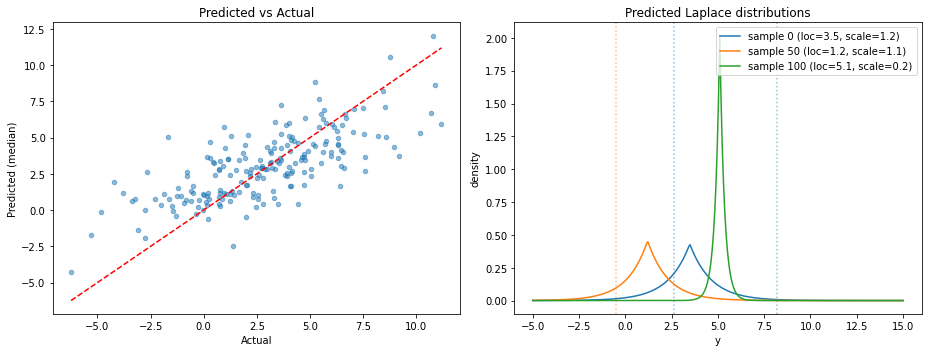

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
lims = [Y_test.min(), Y_test.max()]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted (median)")
ax.set_title("Predicted vs Actual")

ax = axes[1]
x = np.linspace(-5, 15, 300)
for i in [0, 50, 100]:
    pdf = scipy.stats.laplace.pdf(x, loc=dists.loc[i], scale=dists.scale[i])
    ax.plot(x, pdf, label=f"sample {i} (loc={dists.loc[i]:.1f}, scale={dists.scale[i]:.1f})")
    ax.axvline(Y_test[i], color=ax.lines[-1].get_color(), linestyle=":", alpha=0.5)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted Laplace distributions")
ax.legend()

plt.tight_layout()
plt.show()